# Image Classification 

# Human Pose Classification

In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidi

## Load Data

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from datasets import load_dataset

dataset = load_dataset("Bingsu/Human_Action_Recognition", split='train')

README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/98.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5400 [00:00<?, ? examples/s]

In [4]:
dataset

Dataset({
    features: ['image', 'labels'],
    num_rows: 12600
})

In [5]:
dataset = dataset.shuffle().train_test_split(test_size = 0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 10080
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 2520
    })
})

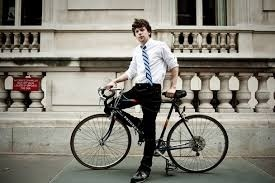

In [6]:
dataset['train'][0]['image']

In [7]:
labels = dataset['train'].features['labels'].names

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i

    id2label[i] = label

print(label2id,"\n\n",id2label)

{'calling': 0, 'clapping': 1, 'cycling': 2, 'dancing': 3, 'drinking': 4, 'eating': 5, 'fighting': 6, 'hugging': 7, 'laughing': 8, 'listening_to_music': 9, 'running': 10, 'sitting': 11, 'sleeping': 12, 'texting': 13, 'using_laptop': 14} 

 {0: 'calling', 1: 'clapping', 2: 'cycling', 3: 'dancing', 4: 'drinking', 5: 'eating', 6: 'fighting', 7: 'hugging', 8: 'laughing', 9: 'listening_to_music', 10: 'running', 11: 'sitting', 12: 'sleeping', 13: 'texting', 14: 'using_laptop'}


## Image Preprocessing

In [8]:
from transformers import AutoImageProcessor

model_ckpt = 'google/vit-base-patch16-224-in21k'

2025-09-23 23:34:35.335622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758670475.536366      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758670475.596114      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

image_processor = AutoImageProcessor.from_pretrained(model_ckpt, use_fast=True)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (image_processor.size['shortest_edge'] if 'shortest_edge' in image_processor.size 
        else (image_processor.size['height'], image_processor.size['width']))

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

def transforms(batch):
    batch['pixel_values'] = [_transforms(img.convert('RGB')) for img in batch['image']]

    del batch['image']

    return batch

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [10]:
dataset = dataset.with_transform(transforms)

## Evaluate the model

In [11]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## Vision Transformer (ViT) Fine Tuning for Image Classification 

In [12]:
from transformers import AutoModelForImageClassification
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = AutoModelForImageClassification.from_pretrained(
    model_ckpt,
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id
).to(device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Model Training

In [13]:
from transformers import TrainingArguments, Trainer


args = TrainingArguments(
    output_dir="train_dir",
    remove_unused_columns=False,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    logging_dir='./logs',         
    logging_steps=10,             
    disable_tqdm=False,           
    report_to="none" 
)


trainer = Trainer(
    model = model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics
)

In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.594800,1.588003,0.709524
2,1.186900,1.218399,0.750000
3,1.023800,1.094045,0.759127
4,1.036100,1.031659,0.761111
5,0.894100,1.004727,0.769048


TrainOutput(global_step=1575, training_loss=1.3102870577857608, metrics={'train_runtime': 1293.0403, 'train_samples_per_second': 38.978, 'train_steps_per_second': 1.218, 'total_flos': 3.906051336688435e+18, 'train_loss': 1.3102870577857608, 'epoch': 5.0})

In [15]:
trainer.evaluate()

{'eval_loss': 0.9900557994842529,
 'eval_accuracy': 0.7781746031746032,
 'eval_runtime': 23.8363,
 'eval_samples_per_second': 105.721,
 'eval_steps_per_second': 3.314,
 'epoch': 5.0}

In [17]:
import shutil

# === Save model + tokenizer === 
save_dir = 'vit-human-pose-classification'
trainer.save_model(save_dir)           

print(f"✅ Model and tokenizer saved in: {save_dir}")

# === Zip the folder ===
zip_filename = f"{save_dir}.zip"
shutil.make_archive(save_dir, 'zip', save_dir)
print(f"✅ Model zipped at: {zip_filename}")

# === Download ===
from IPython.display import FileLink
display(FileLink(zip_filename))

✅ Model and tokenizer saved in: vit-human-pose-classification
✅ Model zipped at: vit-human-pose-classification.zip


/kaggle/working/vit-human-pose-classification.zip

# Classification Report and Confusion Matrix

                    precision    recall  f1-score   support

           calling       0.60      0.66      0.62       145
          clapping       0.82      0.81      0.81       173
           cycling       0.94      0.94      0.94       171
           dancing       0.84      0.82      0.83       168
          drinking       0.83      0.80      0.81       171
            eating       0.85      0.81      0.83       166
          fighting       0.84      0.84      0.84       172
           hugging       0.82      0.85      0.83       188
          laughing       0.76      0.82      0.79       153
listening_to_music       0.76      0.67      0.71       168
           running       0.83      0.87      0.85       157
           sitting       0.59      0.64      0.61       168
          sleeping       0.82      0.87      0.85       167
           texting       0.66      0.64      0.65       177
      using_laptop       0.76      0.70      0.73       176

          accuracy                    

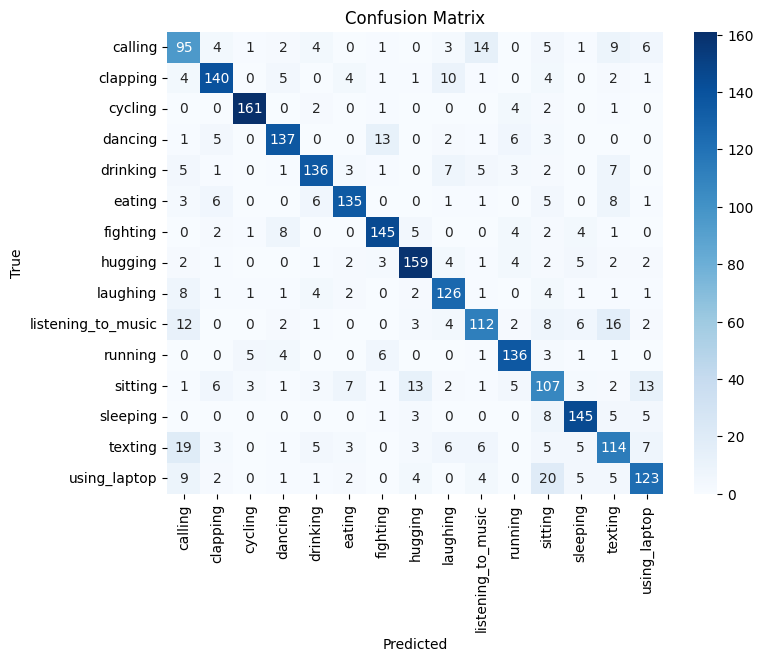

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Run prediction
pred_output = trainer.predict(dataset['test'])

# Extract logits and true labels
logits = pred_output.predictions
y_pred = np.argmax(logits, axis=1)
y_true = pred_output.label_ids

# Classification report
print(classification_report(y_true, y_pred, target_names=labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Prediction in Real Image 

In [20]:
from transformers import pipeline
from transformers import AutoImageProcessor

model_ckpt = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_ckpt, use_fast=True)

pipe = pipeline('image-classification', model='vit-human-pose-classification', 
                image_processor=image_processor)

url = "https://images.pexels.com/photos/1755385/pexels-photo-1755385.jpeg"

output = pipe(url)
output

Device set to use cuda:0


[{'label': 'sitting', 'score': 0.5307165384292603},
 {'label': 'sleeping', 'score': 0.06453327089548111},
 {'label': 'using_laptop', 'score': 0.06329386681318283},
 {'label': 'listening_to_music', 'score': 0.0456068217754364},
 {'label': 'texting', 'score': 0.04358245059847832}]

In [21]:
image_processor.save_pretrained('vit-human-pose-classification')

['vit-human-pose-classification/preprocessor_config.json']

## Load from local files

In [1]:
# Load the model and image processor from the local directory
from transformers import AutoImageProcessor, AutoModel

local_directory = 'vit-human-pose-classification'
image_processor = AutoImageProcessor.from_pretrained(local_directory, use_fast=True)
model = AutoModel.from_pretrained(local_directory, local_files_only=True)

Some weights of ViTModel were not initialized from the model checkpoint at vit-human-pose-classification and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Push Model to AWS S3

In [2]:
import boto3
import os


s3 = boto3.client('s3')
bucket_name = 'mlops-test-abdullah'
model_path = 'vit-human-pose-classification'

def upload_folder(Bucket, dir_path, s3_prefix):
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            filepath = os.path.join(root, file)
            s3_key = os.path.join(s3_prefix, file)

            s3.upload_file(filepath, Bucket, s3_key)

            
upload_folder(Bucket= bucket_name ,dir_path=model_path, s3_prefix="ml-models/vit-human-pose-classification")